In [1]:
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import os
import yfinance as yf

from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Conv1D, Conv1DTranspose
from keras.layers import LSTM, LeakyReLU, ELU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

In [3]:
# getting our dataset
data = yf.download('BTC-USD', end='2023-01-01')
data = data.reset_index()
data['tmrw_close'] = data['Close'].shift(-1) 

data = data.set_index('Date')
data = data.asfreq('D')
data = data.sort_index()

# since we shifted everything up one, the very last value for tmrw_close is NA. we need to fill that in
data['tmrw_close'] = data['tmrw_close'].fillna(method='ffill', limit=2)
print("shape(rows, features):",data.shape)
data

[*********************100%***********************]  1 of 1 completed
shape(rows, features): (3028, 7)


,Open,High,Low,Close,Adj Close,Volume,tmrw_close
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,402.152008
...,...,...,...,...,...,...,...
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,16717.173828,15748580239,16552.572266
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,16552.572266,17005713920,16642.341797
2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797,16642.341797,14472237479,16602.585938


In [4]:
# Preprocess the data
data = data.dropna()
data = data.loc[:, ['Close', 'Volume', 'tmrw_close']]

if data.isnull().values.any():
    print("Warning: Missing values detected in data.")
else:
    print("No missing values found")
print("shape(rows, features):",data.shape)
data

No missing values found
shape(rows, features): (3028, 3)


,Close,Volume,tmrw_close
Date,,,
2014-09-17,457.334015,21056800,424.440002
2014-09-18,424.440002,34483200,394.795990
2014-09-19,394.795990,37919700,408.903992
2014-09-20,408.903992,36863600,398.821014
2014-09-21,398.821014,26580100,402.152008
...,...,...,...
2022-12-27,16717.173828,15748580239,16552.572266
2022-12-28,16552.572266,17005713920,16642.341797
2022-12-29,16642.341797,14472237479,16602.585938


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [6]:
data

array([[4.14358659e-03, 4.31449241e-05, 3.65546321e-03],
       [3.65546321e-03, 8.14009147e-05, 3.21556748e-03],
       [3.21556748e-03, 9.11925723e-05, 3.42492004e-03],
       ...,
       [2.44317410e-01, 4.12190545e-02, 2.43727462e-01],
       [2.43727462e-01, 4.53702883e-02, 2.42909968e-01],
       [2.42909968e-01, 3.20070863e-02, 2.42909968e-01]])

In [7]:
# Define the generator model
def make_generator_model():
    model = Sequential([
        Dense(256, input_shape=(100,), kernel_initializer=RandomNormal(stddev=0.02)),
        BatchNormalization(),
        Dense(512),
        BatchNormalization(),
        Dense(1024),
        BatchNormalization(),
        Dense(2048),
        BatchNormalization(),
        Dense(4096),
        BatchNormalization(),
        Dense(2048),
        BatchNormalization(),
        Dense(1024),
        BatchNormalization(),
        Dense(512),
        BatchNormalization(),
        Dense(256),
        BatchNormalization(),
        Dense(365*3, activation='sigmoid'),
        Reshape((365, 3))
    ])
    return model

# Define the discriminator model
def make_discriminator_model():
    model = Sequential([
        Conv1D(64, 3, strides=2, padding='same', input_shape=(365, 3)),
        Dropout(0.5),
        Conv1D(128, 3, strides=2, padding='same'),
        Dropout(0.5),
        Conv1D(256, 3, strides=2, padding='same'),
        Dropout(0.5),
        Conv1D(512, 3, strides=2, padding='same'),
        Dropout(0.5),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Combine the generator and discriminator models to form a GAN
def make_gan_model(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    gan_output = discriminator(generator(gan_input))
    model = Model(gan_input, gan_output)
    return model

In [8]:
# Set hyperparameters
epochs = 1001
batch_size = 128

# Create the generator, discriminator, and GAN models
generator = make_generator_model()
discriminator = make_discriminator_model()
gan = make_gan_model(generator, discriminator)

# Compile the discriminator
discriminator.compile(loss='binary_cross_entropy', optimizer=Adam(learning_rate=1e-4, beta_1=0.5))

# Compile the GAN
gan.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-4, beta_1=0.5))

In [9]:
# Assuming data is a numpy array of shape (num_samples, 3)
new_data = data[:, [0, 2]]
num_samples = data.shape[0]
time_steps = 365
features = 3

# Create a new numpy array of shape (num_samples - time_steps + 1, time_steps, features)
new_data = np.zeros((num_samples - time_steps + 1, time_steps, features))

# Fill the new numpy array with rolling windows of size time_steps
for i in range(num_samples - time_steps + 1):
    new_data[i] = data[i:i+time_steps, :]

print(new_data.shape)

(2664, 365, 3)


In [ ]:
# create output data for generated data
if not os.path.exists('/content/output'):
  os.makedirs('/content/output')

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Train the GAN
for epoch in range(epochs):
    # Train the discriminator
    idx = np.random.randint(0, new_data.shape[0], batch_size)
    real_data = new_data[idx]
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_data = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # Train the generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
    # Print progress
    print(f'Epoch {epoch+1}/{epochs} - D loss: {d_loss} - G loss: {g_loss}')
    # Save generated samples every 100 epochs
    if (epoch+1) % 500 == 0:
        noise = np.random.normal(0, 1, (1, 100))
        generated_data = generator.predict(noise)
        generated_data = generated_data.reshape((365, 3))
        generated_data = scaler.inverse_transform(generated_data)
        generated_data = pd.DataFrame(generated_data, columns=['Close', 'Volume', 'tmrw_close'])
        generated_data.to_csv(f'/content/output/generated_data_epoch{epoch+1}.csv', index=False)

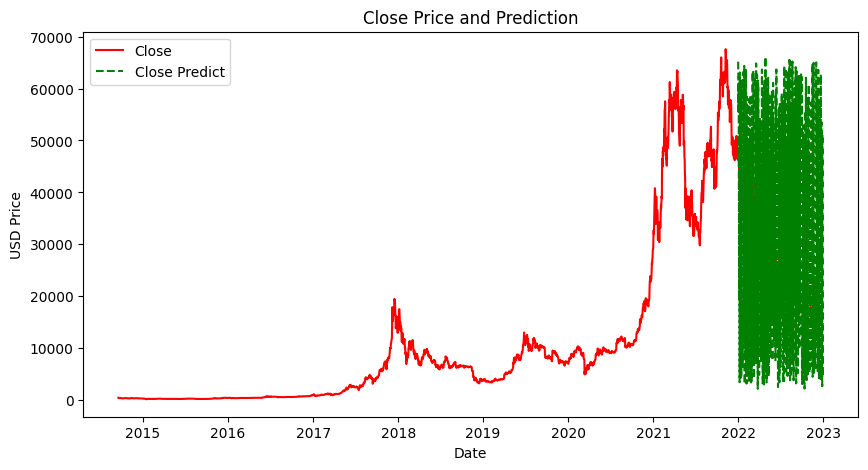

In [12]:
import matplotlib.pyplot as plt
reversed_data = scaler.inverse_transform(data) 
df = pd.DataFrame(reversed_data, columns=['Close', 'Volume', 'tmrw_close'])
df.index = pd.date_range(start='2014-09-17', periods=len(df), freq='D')

df_generated = pd.read_csv('/content/output/generated_data_epoch2000.csv')
df_generated.index = pd.date_range(start='2022-01-01', periods=len(df_generated), freq='D')

# # Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df.index, df['Close'], label='Close', color='red')

ax.plot(df_generated.index, df_generated['Close'], label='Close Predict', linestyle='--', color='green')

ax.set_xlabel('Date')
ax.set_ylabel('USD Price')
ax.set_title('Close Price and Prediction')
ax.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# equate index of real data with generated data so that it can be evaluated
one_year = len(df) - 365
df = df.iloc[one_year:].copy()

# calculate the correlation coefficient between two columns
corr = np.corrcoef(df['Close'], df_generated['Close'])[0, 1]

# calculate MAE, RMSE between two columns
mae = mean_absolute_error(df['Close'], df_generated['Close'])
rmse = np.sqrt(mean_squared_error(df['Close'], df_generated['Close']))

# print the MAE and RMSE
print("MAE:", mae)
print("RMSE:", rmse)
# print the correlation coefficient
print("Correlation coefficient:", corr)

MAE: 20838.59366225171
RMSE: 24273.702660545165
Correlation coefficient: 0.06824540231567582
